In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
# Reading the dataset from csv file and putting it into a dataframe
df = pd.read_csv("diabetes.csv")
print(df.shape)

(768, 9)


In [3]:
"""
Showing dataframe info and describing it.
As you can see, glucose, blood pressure, skin thickness, insulin level, BMI columns include some 0 values. This is impossible.
Some operations will be held on those data.
"""
print(df.info())
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
                          count        mean         std     min       25%       50%        75%     max
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000    3.0000    6.00000   17.00
Glucose                   768

In [4]:
# A method to distinguish columns
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print()
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"How many empty values for each column: \n{df.isnull().sum()}\n")

# A method to calculate upper and lower boundaries of the related column according to two quantiles.
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# A method to check is any outlier exists in the related column
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# A method to find the outliers in the related column
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

# A method to suppress outlier values with the upper or lower boundary value depending on the situation
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Suppresing the numerical columns' outliers
for col in num_cols:
    replace_with_thresholds(df, col)

# Pregnancies and outcome columns can have zero values, but others can't
keep_columns_same = ["Pregnancies", "Outcome"]
zero_to_nan = [col for col in df.columns if col not in keep_columns_same]

# The columns that can't include any zero value are replaced by the "NaN" value
for col in zero_to_nan:
    df[col] = df[col].replace(0, np.nan)

"""
A method to fill any missing value.
If the outcome value for the missing cell is 1, this cell is filled by the means of values that have outcome value 1
If the outcome value for the missing cell is 0, this cell is filled by the means of values that have outcome value 0
""" 
def fill_with_mean(item, col, mean_of_zeros, mean_of_ones):
    if item["Outcome"] == 0 and pd.isna(item[col]):
        return mean_of_zeros
    elif item["Outcome"] == 1 and pd.isna(item[col]):
        return mean_of_ones
    else:
        return item[col]

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1

How many empty values for each column: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64



In [5]:
# Showing the outcome values' means according to the related columns
print("The average of target variable according to the categorical variables:")
for col in cat_cols:
    print(df.groupby(col)["Outcome"].mean())

The average of target variable according to the categorical variables:
Outcome
0    0.0
1    1.0
Name: Outcome, dtype: float64


In [6]:
# Showing the related column's means according to the outcome values 
print("The average of numerical variables according to the target variable:")
for col in num_cols:
    print(df.groupby("Outcome")[col].mean())

The average of numerical variables according to the target variable:
Outcome
0    3.298000
1    4.843284
Name: Pregnancies, dtype: float64
Outcome
0    110.202750
1    141.534515
Name: Glucose, dtype: float64
Outcome
0    69.508000
1    72.880597
Name: BloodPressure, dtype: float64
Outcome
0    27.235457
1    32.894444
Name: SkinThickness, dtype: float64
Outcome
0    123.321496
1    184.679808
Name: Insulin, dtype: float64
Outcome
0    30.527500
1    35.105597
Name: BMI, dtype: float64
Outcome
0    0.420264
1    0.531022
Name: DiabetesPedigreeFunction, dtype: float64
Outcome
0    31.135000
1    37.052239
Name: Age, dtype: float64


In [7]:
# Filling the "NaN" values by the method explained above
for col in zero_to_nan:
    means_df = df.groupby("Outcome")[col].mean()
    mean_of_zero_outcomes = means_df.values[0]
    mean_of_one_outcomes = means_df.values[1]
    df[col] = df.apply(lambda x: fill_with_mean(x, col, mean_of_zero_outcomes, mean_of_one_outcomes), axis=1)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1


In [8]:
# Checking the columns, if there any outliers still exist
for col in df.columns:
    print(f"{col} has outlier: {check_outlier(df, col)}")

for col in df.columns:
    print(f"{col} has outliers at index: {grab_outliers(df, col, index=True)}")

Pregnancies has outlier: False
Glucose has outlier: False
BloodPressure has outlier: False
SkinThickness has outlier: True
Insulin has outlier: True
BMI has outlier: False
DiabetesPedigreeFunction has outlier: False
Age has outlier: False
Outcome has outlier: False
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Pregnancies has outliers at index: Int64Index([], dtype='int64')
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Glucose has outliers at index: Int64Index([], dtype='int64')
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
BloodPressure has outliers at index: Int64Index([], dtype='int64')
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction   Age  Outcome
8   

[-2.52239323 -2.51323703 -2.31363745 -2.1657635  -1.88972348 -1.88971516
 -1.82477396 -1.72006952 -1.70803312 -1.64996711 -1.61790387 -1.58350764
 -1.57823493 -1.57252403 -1.57088691 -1.56348624 -1.5547967  -1.53227671
 -1.52070854 -1.50562745 -1.49715919 -1.49381992 -1.47340808 -1.44539367
 -1.43136517 -1.42940975 -1.42552765 -1.42481878 -1.41440709 -1.40609795
 -1.40247662 -1.40029059 -1.39585774 -1.39438885 -1.38540121 -1.37424495
 -1.36916878 -1.36801415 -1.36761324 -1.36187261 -1.36111081 -1.35818082
 -1.35614709 -1.35126422 -1.34880895 -1.3485025  -1.34759562 -1.34665408
 -1.3460657  -1.34546631 -1.34317254 -1.34306522 -1.34191638 -1.33812978
 -1.33766853 -1.33697073 -1.33482741 -1.33180313 -1.3304578  -1.32984822
 -1.32856244 -1.32647288 -1.32436864 -1.32184914 -1.32138134 -1.32087114
 -1.31865542 -1.3112162  -1.31032325 -1.30675317 -1.30648884 -1.30281627
 -1.29843128 -1.29671102 -1.2959941  -1.28929765 -1.2870483  -1.28509597
 -1.28490268 -1.28412697 -1.28349543 -1.28276509 -1

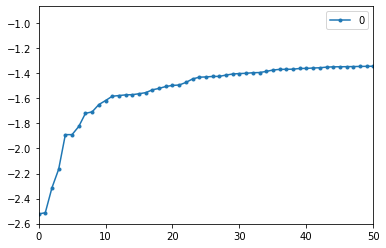

-1.578234931413074
(12, 9)
Int64Index([75, 120, 182, 323, 342, 349, 445, 453, 502, 537, 579, 711], dtype='int64')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1


In [9]:
# Applying a LOF part to catch multiple variable outliers
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(np.sort(df_scores))

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show(block=True)

th = np.sort(df_scores)[12]
print(th)
print(df[df_scores < th].shape)
print(df[df_scores < th].index)

df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)
df

In [10]:
# Sorting and creating new features for the dataset
df['NewGlucose'] = pd.cut(x=df['Glucose'], bins=[0, 70, 99, 126, 200], labels=["Low", "Normal", "Secret", "High"])
df['NewBMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=["Underweight", "Normal", "Overweight", "Obese"])
df.loc[(15 <= df['Insulin']) & (df['Insulin'] <= 166), 'NewInsulin'] = 'Normal'
df.loc[166 < df['Insulin'], 'NewInsulin'] = 'Abnormal'

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose,NewBMI,NewInsulin
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1,High,Obese,Abnormal
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0,Normal,Overweight,Normal
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1,High,Normal,Abnormal
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,Normal,Overweight,Normal
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1,High,Obese,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0,Secret,Obese,Abnormal
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0,Secret,Obese,Normal
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0,Secret,Overweight,Normal
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1,Secret,Obese,Abnormal


In [11]:
# Encoding the dataframe columns
encoded_df = pd.get_dummies(df, drop_first=True)
encoded_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High,NewBMI_Normal,NewBMI_Overweight,NewBMI_Obese,NewInsulin_Normal
0,6.0,148.0,72.0,35.000000,184.679808,33.6,0.627,50.0,1,0,0,1,0,0,1,0
1,1.0,85.0,66.0,29.000000,123.321496,26.6,0.351,31.0,0,1,0,0,0,1,0,1
2,8.0,183.0,64.0,32.894444,184.679808,23.3,0.672,32.0,1,0,0,1,1,0,0,0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,1,0,0,0,1,0,1
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0,0,1,0,0,0,1,0
764,2.0,122.0,70.0,27.000000,123.321496,36.8,0.340,27.0,0,0,1,0,0,0,1,1
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0,0,1,0,0,1,0,1
766,1.0,126.0,60.0,32.894444,184.679808,30.1,0.349,47.0,1,0,1,0,0,0,1,0


In [12]:
# Showing the last version of related columns
cat_cols, num_cols, cat_but_car = grab_col_names(encoded_df)

# Applying MinMaxScaler to fit the data into [0,1] interval without corrupting the existing distribution
scaler = MinMaxScaler()
encoded_df[num_cols] = scaler.fit_transform(encoded_df[num_cols])

encoded_df

Observations: 756
Variables: 16
cat_cols: 8
num_cols: 8
cat_but_car: 0
num_but_cat: 8



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewGlucose_Normal,NewGlucose_Secret,NewGlucose_High,NewBMI_Normal,NewBMI_Overweight,NewBMI_Obese,NewInsulin_Normal
0,0.444444,0.670968,0.513889,0.528302,0.559768,0.544355,0.489305,0.637363,1,0,0,1,0,0,1,0
1,0.074074,0.264516,0.430556,0.415094,0.357349,0.356183,0.243316,0.219780,0,1,0,0,0,1,0,1
2,0.592593,0.896774,0.402778,0.488574,0.559768,0.267473,0.529412,0.241758,1,0,0,1,1,0,0,0
3,0.074074,0.290323,0.430556,0.301887,0.260619,0.396505,0.079323,0.000000,0,1,0,0,0,1,0,1
4,0.000000,0.600000,0.069444,0.528302,0.504742,0.799731,1.000000,0.263736,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.740741,0.367742,0.569444,0.773585,0.544330,0.525538,0.082888,0.923077,0,0,1,0,0,0,1,0
764,0.148148,0.503226,0.486111,0.377358,0.357349,0.630376,0.233512,0.131868,0,0,1,0,0,0,1,1
765,0.370370,0.496774,0.513889,0.301887,0.320000,0.345430,0.148841,0.197802,0,0,1,0,0,1,0,1
766,0.074074,0.529032,0.347222,0.488574,0.559768,0.450269,0.241533,0.571429,1,0,1,0,0,0,1,0


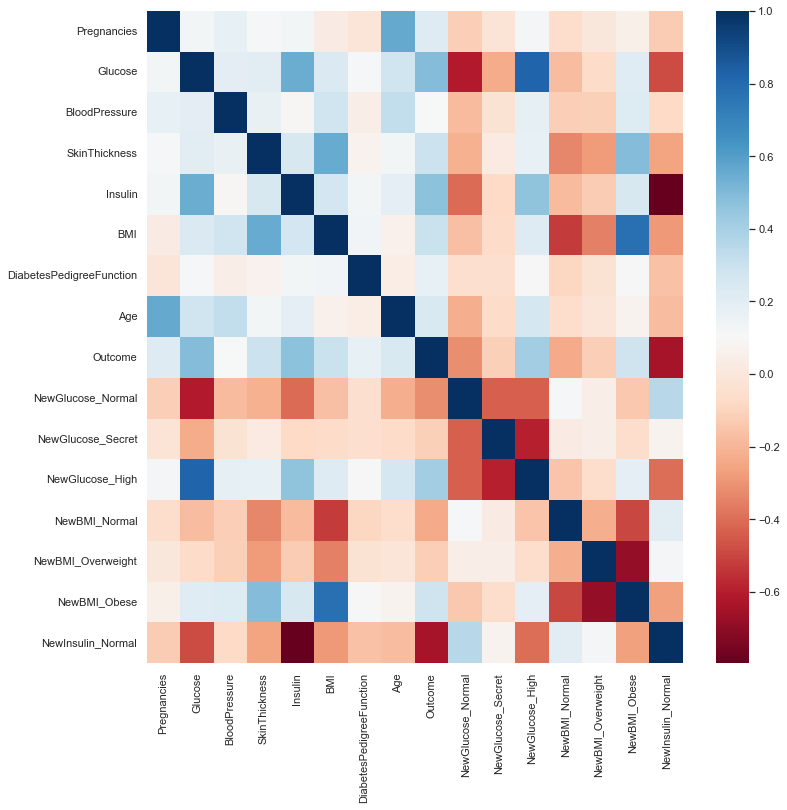

In [13]:
# Showing the correlations
corr = encoded_df.corr()
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show(block=True)

In [14]:
# Splitting the train and test splits
y = encoded_df["Outcome"]
X = encoded_df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Creating a Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Showing the accuracy and F1 score according to the 5-fold cross validation
print(f'Average accuracy is: {cross_val_score(model, X, y, cv=5).mean()}')
print(f'Average F1 score is: {cross_val_score(model, X, y, scoring="f1", cv=5).mean()}')

Average accuracy is: 0.8809515510630881
Average F1 score is: 0.8242024124742571
